# Virtual ADC example
---

Welcome to the Virtual ADC example of X-HEEP's FEMU! 
This notebook will demonstrate how to: 
1. Take a signal from a `.txt` file and convert it to a `Timeseries` variable (a simple format to store signals in Python without needing to know additional information or parsing).
1. Load a signal from a `Timeseries` variable and feed it to the virtual ADC. 
1. Interact with the X-HEEP's C code from this notebook through a `definitions.h` file.  
1. Launch an application on X-HEEP that will receive the virtual ADC's input and output the result of applying a filter through the UART.
1. Plot the results obtained from X-HEEP's execution. 
1. Obtain performance measurements from the execution and plot them to spot bottlenecks and compare them to application requirements.

---


## Initialization

Firstly some key paths are set and added to the system path. 

Then the bitstream of X-HEEP + the necessary peripherals to interact with the FEMU (`x_heep.bit`) is loaded. It should be located in `~/x-heep-femu-sdk/hw/` (w.r.t. this notebook: `../../../../hw/`). 

In [9]:
%reload_ext autoreload
%autoreload 2
# Import the X-HEEP Python class
from pynq import x_heep

# Allow the import of all modules in this directory
import sys
SDK_PATH        = '/home/xilinx/x-heep-femu-sdk/sw/'            # Path to the SDK of the FEMU
RISCV_PATH      = 'riscv/'                                      # Path to the RISCV files
APP_PATH        = SDK_PATH + RISCV_PATH + 'apps/adc-emu/'       # Path to the .c file of the ADC-emu application
ADC_BIN_NAME    = 'adc_in'                                      # Name of the file that will be used as ADC input    
NB_PATH         = SDK_PATH + 'arm/jupyter_notebooks/adc-emu/'   # Path to this notebook         

sys.path.append(SDK_PATH + "arm/sdk/")

# Load the X-HEEP bitstream
xh = x_heep()

## Generating a Timeseries variable

The `timeseries` module of the SDK allows to treat different signals and perform common operations over them. In this demo a `.txt` file is read containing data values for an EEG signal of 2 seconds of duration. In your app you can take any file, extract its values and timestamps and generate a `Timeseries` variable to use with this demo. 

* You can change the variable `SKIP_PKL_GEN` to 1 to avoid reading the input file and generating the `.pkl` file each time

In [10]:
import numpy as np
from timeseries import Timeseries

# Fixed information on where input and output data should be stored, and in which format
PATH_IN         = 'in/'
PATH_OUT        = 'out/'
EXTENSION_IN    = '.txt'
EXTENSION_OUT   = '.pkl'

In [11]:
# The file to be converted. 
# It should contain a single data point per line and nothing else. 
# No header information. 
FILENAME = 'Biopac'  
TIME_s  = 60
# Skip the process of reading the file and generating the timeseries variable (.pkl). 
# This process takes several seconds and might be preferable to skip it if no changes were made to the original signal. 
SKIP_PKL_GEN = 1

if SKIP_PKL_GEN: print("⏩ Skipped signal generation")
else:

    # Open the file and read the values
    y = []
    with open(NB_PATH + PATH_IN + FILENAME + EXTENSION_IN) as f:
        y = f.readlines()

    # Parse the data into numbers
    data = np.asarray([int(np.round(float(f))) for f in y])

    # Compute the timing information based on the TIME_s variable set before
    s_n = len(data)
    T_s = TIME_s/s_n
    f_Hz = s_n/TIME_s
    time = np.arange(0,TIME_s,T_s)

    # Create the timeseries variable
    signal = Timeseries('Raw')
    signal.data = data
    signal.time = time
    signal.f_Hz = f_Hz
    # Dump the timeseries variable into a .pkl file
    signal.dump( path = NB_PATH + PATH_OUT, name = FILENAME)

    print(f"Signal frequency: {signal.f_Hz} Hz")
    print(f"Signal length: {s_n} samples ({TIME_s} seconds)")

⏩ Skipped signal generation


## Generate an input array

The `.pkl` variable can be read and use as input signal to the `virtual ADC`. This is a good moment to subsample or modify your signal before feeding it to X-HEEP. Once the signal is as desired it will be exported to the `adc_in.bin` file that is stored along the C code for X-HEEP in `~/x-heep-femu-sdk/sw/riscv/apps/adc-emu/`. 



In [12]:
import numpy as np
from timeseries import Timeseries

INPUT_DATA_LENGTH       = 2560
INPUT_BUFFER_SIZE       = 50
FREQ_VADC_SAMPLING_HZ = 700*1e3

# Load the data as a timeseries
din = Timeseries.load(NB_PATH + PATH_OUT + FILENAME + EXTENSION_OUT)

# Turn all values into unsigned by offsetting them
din.data  += abs(min(din.data))

# To abide by the memory constraint, downsample the signal
inital_samples = len(din.data)
downsample = int(inital_samples/INPUT_DATA_LENGTH)
din.data = din.data[INPUT_DATA_LENGTH::downsample]
din.time = din.time[INPUT_DATA_LENGTH::downsample]

# Export the binary file to the application folder
din.export_bin(path=APP_PATH, name=ADC_BIN_NAME)

INPUT_DATA_LENGTH = len(din.data)
print(f"Set {INPUT_DATA_LENGTH} of {inital_samples} words as input")

Set 2549 of 231924 words as input


## Share information with the C code

A `definitions.h` file is created to share data between this notebook and the C code. You can add any kind of `#define` (including macros) to the code. 
In this case it is used to share strings that will be used by the software to parse a result and print it so we can extract it from the UART to plot it.  
We also share vADC sampling information to be used in configuring the acquisition.

In [ ]:
# Enable the printfs inside X-HEEP application. 
# This is not the same as VERBOSE, as 
#   a) it actually reflects in C-code and therefore in performance.
#   b) Will not allow to read the output to plot in this notebook
ENABLE_PRINTF       = 1

# Define some standards to parse the X-HEEP output
OUTPUT_START_SEQ    = "# "
OUTPUT_DIVIDER      = "|"
OUTPUT_END_SEQ      = "#---"   

# Write the definitions header file to share information with the C code
defs = APP_PATH + 'definitions.h'
xh.open_definitions     (defs, "DEFINITIONS")
xh.add_definition       (defs, "INPUT_DATA_LENGTH", INPUT_DATA_LENGTH )
xh.add_definition       (defs, "INPUT_BUFFER_SIZE", INPUT_BUFFER_SIZE )
xh.add_definition       (defs, "WORD_SIZE_BYTES",   4 )
xh.add_definition       (defs, "VADC_SAMPLING_FREQ_HZ", FREQ_VADC_SAMPLING_HZ )
xh.add_definition       (defs, "ENABLE_PRINTF",     ENABLE_PRINTF)
xh.add_definition       (defs, "OUTPUT_START_SEQ",  OUTPUT_START_SEQ)
xh.add_definition       (defs, "OUTPUT_DIVIDER",    OUTPUT_DIVIDER)
xh.add_definition       (defs, "OUTPUT_END_SEQ",    OUTPUT_END_SEQ)
xh.close_definitions    (defs)

## Compile the code and run the application

The C code written for X-HEEP in `~/x-heep-femu-sdk/sw/riscv/apps/adc-emu/adc-emu.c` will be compiled to generate the `code.*` files in `~/x-heep-femu-sdk/sw/build/`. This will be later loaded into X-HEEP for it to execute. 

After compilation, the `virtual ADC` is initialized with the signal that will be fed.

Before running the program performance counters are reset and started. These will capture the execution of X-HEEP and will be used to asses the latency of the execution and average power of each block of X-HEEP. 

During the exeuction the UART output will be printed live. 

* You can change the variable `SKIP_COMPILE`  to 1 to avoid compiling each time.
* You can change the variable `VERBOSE`       to 0 to supress the live printing of the UART.

In [16]:
# Skip compiling if all you want to do is run the application
# Note that the compilation is affected by the parameters written to the definitions.h file
SKIP_COMPILE    = 0
# Wether to see the X-HEEP UART output live.
VERBOSE         = 0

# Compile the application
if SKIP_COMPILE: print("⏩ Skipped compilation") 
else:
    xh.compile_app("adc-emu")

    data_file_name = APP_PATH + ADC_BIN_NAME + ".bin"
    ddr_thread, ddr_sf = xh.virtual_adc_thread_start(data_file_name)

    perf_cnt = xh.init_perf_cnt()           # Init the performance counters
    xh.reset_perf_cnt(perf_cnt)             # Reset the performance counters
    xh.start_perf_cnt_manual(perf_cnt)      # Start the performance counters

    out, _ = xh.run_app(verbose = VERBOSE)  # Run the application (disregarding the error output)

    xh.stop_perf_cnt(perf_cnt)              # Stop the performance counters
    xh.thread_stop(ddr_thread, ddr_sf)      # Stop the ddr circular buffer controller
    


✅ Compile SUCCESS
✅ Return SUCCESS
 


### Parse the UART output

Until now most steps were significantly _"application-agnostic"_. The parsing of the output will strongly depend on what you are trying to extract from X-HEEP.

In [17]:
# Extract the UART output from X-HEEP
app_out = xh.uart_data

# Find positions of strings starting with "#"
starts = [i for i, s in enumerate(app_out) if s.startswith(OUTPUT_START_SEQ)]
# Find positions of strings starting with "#"
ends = [i for i, s in enumerate(app_out) if s.startswith(OUTPUT_END_SEQ)]

# Sanity check to make sure that all output lists are closed
if len(starts) != len(ends): sys.exit("❌ Invalid output")

# Will divide the outputs in a list of dictionaries containing headers and data
outs = []
for seq in range(len(starts)):
    s = starts[seq]
    e = ends[seq]
    # Strip the headers of the format markers
    headers = app_out[s].split(OUTPUT_DIVIDER)
    headers = [ h.strip().replace(OUTPUT_START_SEQ,'') for h in headers ]
    # Strip the data of the format markers and covert it into a numpy array of integers
    data  = [line.split(OUTPUT_DIVIDER) for line in app_out[s+1:e]]
    data = np.asarray([ [int(i.strip()) for i in d] for d in data ]).T
    # Add the result to the list of dictionaries
    outs.append( {'headers':headers, 'data':data } )

# Convert all outputs to timeseries
# Each timeseries will be part of a sequence: a group of timeseries of the same length (were printed as different columns of a same process)
# All timeseries of a same sequence share timescale (that could be none)
raw_series = []
for seq in outs:
    seqs = []
    cols_i = 0 
    cols_f = len(seq['headers'])
    time = []
    # If some first column of a sequence is a timestamp array, use it as time of all sequences
    if "time" in seq['headers'][0].lower():
        time = seq['data'][0]
        cols_i = 1
    # For the rest of the sequences just use the data as data
    for c in range(cols_i, cols_f):
        s = Timeseries( seq['headers'][c] )
        s.data = seq['data'][c]
        s.time = time
        seqs.append(s)
    raw_series.append(seqs)
    
# Access the information as `raw_series[0][1].name` (the name of the second column of the first sequence) 
print("Output included", len(raw_series), "sequences")
for s in range(len(raw_series)):
    print(f">>> Sequence {s} has headers: {[ h.name for h in raw_series[s] ]}")

Output included 1 sequences
>>> Sequence 0 has headers: ['Output']


## Plot the input and output

The obtained output will be plotted along with the input data `din`. 

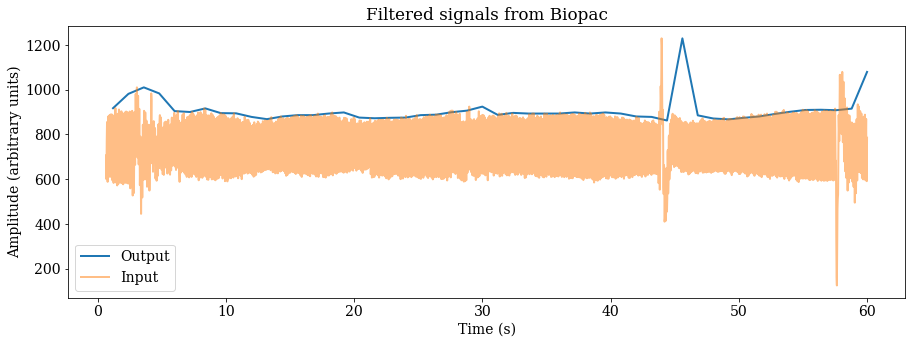

In [18]:
import matplotlib.pyplot as plt

# make a deep copy to ensure that changes to the list will not affect the one obtained from the output
import copy 
series = copy.deepcopy(raw_series)
# Add to the sequence some reference signal
ts = Timeseries("Input")
ts.data = din.data
ts.time = din.time
series[0].append(ts)

# Add some time information based on knowledge of what was input and the expected output
step = max(ts.time)/int(INPUT_DATA_LENGTH/INPUT_BUFFER_SIZE)
series[0][0].time = list(np.arange(step, int(max(ts.time)) + step, step))
series[0][1].time = ts.time

# Generate subplot to show the results
plts = len(series)
plt_height = 5

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 14
FIG_HEIGHT = 4
fig, axs = plt.subplots(ncols=plts, figsize=(3*plt_height*plts, plt_height))

# Plot configurations
a = [1,0.5,0.5] # Alpha (opacity)

# Plot the desired signals
for p in range(plts):
    for s in range(len(series[p])):
        ax = axs if len(series) == 1 else axs[p] 
        if len(series[p][s].time) > 0:
            ax.plot(series[p][s].time, series[p][s].data, 
                    alpha = a[s], linewidth=2)
        else:
            ax.plot(series[p][s].data, 
                    alpha = a[s])
    ax.legend([seq.name for seq in series[p]], loc='lower left')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (arbitrary units)")
    ax.set_title(f"Filtered signals from {FILENAME}")


## Performance and Energy

During the execution of the application performance measurements were generated. In this section we will read them to generate latency and energy estimations. 

The report generated is stored in `~/x-heep-femu-sdk/sw/riscv/build/energy_estim.csv`.

Latency, power and energy results will be computed and can be compared to some defined budgets. 

You can prune your design by removing modules to estimate the power consumption of X-HEEP without these blocks. 

---------------------
  Full System  
Total cycles: 	78.50 ms
Total energy: 	57.93 µJ
Avg power:	737.99 µW
---------------------
  System Pruning  
Latency:	78.50 ms
Energy: 	20.57 µJ
Avg Pwr:	262.09 µW
✅ Latency SUCCESS
✅ Power SUCCESS


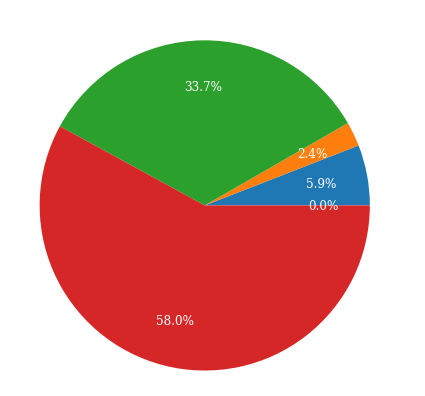

In [19]:
from copy import deepcopy as cp
from report import *

# Define some budgets that we should not cross
POWER_BUDGET_W      = 300e-6
LATENCY_BUDGET_S    = 1

xh.read_perf_cnt(perf_cnt);         # Read the performance counters
xh.estimate_performance(verbose=False);     # Estimate the performance 
xh.estimate_energy("HVT", verbose=False);   # Estimate the energy using the HVT model

print("---------------------")
print("  Full System  ")
rep_summary, rep_latency, rep_energy  = report() # Get the report

print("---------------------")
print("  System Pruning  ")


if 0: # In case you want to print the dictionaries containing the breakdown
    import pprint
    pprint.pprint(rep_energy)

# Remove modules that will not be used in the design. 
# You can check the names in sdk/sw/riscv/build/energy_estim.csv
pruned_energy = cp(rep_energy)
pruned_energy = remove_module(pruned_energy, "debug ao" )
pruned_energy = remove_module(pruned_energy, "uart ao" )
pruned_energy = remove_module(pruned_energy, "spi ao" )
pruned_energy = remove_module(pruned_energy, "spi flash ao" )
pruned_energy = remove_module(pruned_energy, "gpio" )
pruned_energy = remove_module(pruned_energy, "i2c" )
pruned_energy = remove_module(pruned_energy, "timer" )

rep_summary['Energy_J'] = pruned_energy['Total']
rep_summary['Power_W']  = rep_summary['Energy_J']/rep_summary['Latency_s']

print(f"Latency:\t{rep_summary['Latency_s']*1e3:0.2f} ms")
print(f"Energy: \t{rep_summary['Energy_J']*1e6:0.2f} µJ")
print(f"Avg Pwr:\t{rep_summary['Power_W']*1e6:0.2f} µW")

# Check that some contraints are satisfied
if rep_summary['Latency_s'] < LATENCY_BUDGET_S: print("✅ Latency SUCCESS") 
else: print("❌ Latency FAIL")
if rep_summary['Power_W']   < POWER_BUDGET_W:   print("✅ Power SUCCESS")   
else: print("❌ Power FAIL")

# @ToDo: Change to a bar graph (where the objectives can also be plotted)
# Plot a breakdown of the energy consumption
plot_energy( pruned_energy, level=1 )